# Import

In [1]:
import gc
import json
import random
import matplotlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import hyperopt
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix
from tqdm import tqdm_notebook as tqdm
from typing import Dict, Tuple, List
from collections import Counter, defaultdict
from numba import jit 
from datetime import datetime, timedelta
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.core.display import display, HTML
from pylab import rcParams


warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:80% !important; }</style>")) # 表示画面サイズ変更

# ①日本語を表示するためのフォントの指定
# print([f.name for f in fm.fontManager.ttflist])
# ②日本語フォントがない場合
# print(matplotlib.matplotlib_fname())
# ③上記で表示されたフォルダのパスの途中(.../mpl-data/fonts/ttf)に.ttfを格納し、下記を実行
# print(matplotlib.get_cachedir())
# ④上記フォルダ内の"fontlist~.json"を削除して下記でリビルド
# matplotlib.font_manager._rebuild()
# ⑤フォントの一覧に.ttfで追加したフォントが表示されるはず

In [2]:
rcParams["figure.figsize"] = (14, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.6, font=["IPAPGothic"], rc={"lines.linewidth": 2})
sns.set_palette(sns.color_palette(["#42A5F5", "#FFA726", "#66BB6A", "#AB47BC", "#EF5350", "#FFEE58", "#8D6E63", \
                                   "#78909C", "#26C6DA", "#26A69A", "#5C6BC0", "#FF80AB", "#C6FF00", "#BDBDBD"]))

In [3]:
data_dir = None
if _dh == ["/kaggle/working"]:
    data_dir = "/kaggle/input/competition_name/"
else:
    data_dir = "data/m5-forecasting-accuracy/"

# Read data

- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

**File 1: “calendar.csv”**<br>
Contains information about the dates on which the products are sold.
- `date`: The date in a “y-m-d” format.
- `wm_yr_wk`: The id of the week the date belongs to.
- `weekday`: The type of the day (Saturday, Sunday, …, Friday).
- `wday`: The id of the weekday, starting from Saturday.
- `month`: The month of the date.
- `year`: The year of the date.
- `d`: d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 
- `event_name_1`: If the date includes an event, the name of this event.
- `event_type_1`: If the date includes an event, the type of this event.
- `event_name_2`: If the date includes a second event, the name of this event.
- `event_type_2`: If the date includes a second event, the type of this event.
- `snap_CA, snap_TX, and snap_WI`: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed. <br>
※SNAP is federal program that provides food-purchasing assistance for low- and no-income people.


**File 2: “sell_prices.csv”** <br>
Contains information about the price of the products sold per store and date.
- `store_id`: The id of the store where the product is sold. 
- `item_id`: The id of the product.
- `wm_yr_wk`: The id of the week.
- `sell_price`: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


**File 3: “sales_train_validation.csv”**<br>
Contains the historical daily unit sales data per product and store.
- `item_id`: The id of the product.
- `dept_id`: The id of the department the product belongs to.
- `cat_id`: The id of the category the product belongs to.
- `store_id`: The id of the store where the product is sold.
- `state_id`: The State where the store is located.
- `d_1, d_2, …, d_i, … d_1941`: The number of units sold at day i, starting from 2011-01-29.
    - `d_1914 - d_1941` represents the validation rows which we will predict in stage 1
    - `d_1942 - d_1969` represents the evaluation rows which we will predict for the final competition standings.


In [4]:
# calendar_df = pd.read_csv(data_dir + "calendar.csv")
# calendar_df = pd.read_pickle(data_dir + "calendar.pkl")
# calendar_df

In [5]:
# price_df = pd.read_csv(data_dir + "sell_prices.csv")
# price_df = pd.read_pickle(data_dir + "price.pkl")
# price_df

In [6]:
# train_df = pd.read_csv(data_dir + "sales_train_validation.csv")
# train_df = pd.read_csv(data_dir + "sales_train_evaluation.csv")
# train_df = pd.read_pickle(data_dir + "train_eval.pkl")
# train_df

In [7]:
submission = pd.read_csv(data_dir + "sample_submission.csv")
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# calendar_df = reduce_mem_usage(calendar_df)
# price_df = reduce_mem_usage(price_df)
# train_df = reduce_mem_usage(train_df)

In [9]:
# calendar_df.to_pickle(data_dir + "calendar.pkl")
# price_df.to_pickle(data_dir + "price.pkl")
# train_df.to_pickle(data_dir + "train_eval.pkl")

In [10]:
gc.collect()

40

# Processing

In [11]:
# 最終的にはd_1942 - d_1969が評価期間になるので、再度実行する必要あり
# 32GBメモリでも厳しいので、あらかじめカテゴリは置換してね
# for day in range(1914, 1942, 1):
# for day in range(1942, 1970, 1):
#     train_df[f"d_{day}"] = np.nan

In [12]:
# train_df = pd.melt(train_df,
#                    id_vars = ["id", "item_id", "dept_id","store_id", "cat_id", "state_id"],
#                    value_vars = [col for col in train_df.columns if col.startswith("d_")],
#                    var_name = "d",
#                    value_name = "sales")
# train_df

In [13]:
# train_df = train_df.merge(calendar_df, on="d", copy=False)
# train_df

In [14]:
# train_df = train_df.merge(price_df, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
# train_df

In [15]:
# train_df.to_pickle(data_dir + "all_data_eval.pkl")

In [16]:
# all_df = pd.read_pickle(data_dir + "all_data_eval.pkl")
# all_df

In [17]:
# all_df["date"] = pd.to_datetime(all_df["date"])
# all_df.drop("weekday", axis=1, inplace=True)

In [18]:
# all_df.info()

# Feature Engineering

In [19]:
all_df = pd.read_pickle(data_dir + "all_data_eval_encoded_except_id.pkl")
all_df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_evaluation,1444,3,0,1,0,d_1,12.0,2011-01-29,11101,...,1,2011,0,0,0,0,0,0,0,0.459961
1,HOBBIES_1_008_CA_1_evaluation,1444,3,0,1,0,d_2,15.0,2011-01-30,11101,...,1,2011,0,0,0,0,0,0,0,0.459961
2,HOBBIES_1_008_CA_1_evaluation,1444,3,0,1,0,d_3,0.0,2011-01-31,11101,...,1,2011,0,0,0,0,0,0,0,0.459961
3,HOBBIES_1_008_CA_1_evaluation,1444,3,0,1,0,d_4,0.0,2011-02-01,11101,...,2,2011,0,0,0,0,1,1,0,0.459961
4,HOBBIES_1_008_CA_1_evaluation,1444,3,0,1,0,d_5,0.0,2011-02-02,11101,...,2,2011,0,0,0,0,1,0,1,0.459961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_825_WI_3_evaluation,1434,2,9,0,2,d_1969,NaN,2016-06-19,11621,...,6,2016,17,4,3,1,0,0,0,3.980469
47735393,FOODS_3_826_WI_3_evaluation,1435,2,9,0,2,d_1968,NaN,2016-06-18,11621,...,6,2016,0,0,0,0,0,0,0,1.280273
47735394,FOODS_3_826_WI_3_evaluation,1435,2,9,0,2,d_1969,NaN,2016-06-19,11621,...,6,2016,17,4,3,1,0,0,0,1.280273
47735395,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1968,NaN,2016-06-18,11621,...,6,2016,0,0,0,0,0,0,0,1.000000


In [20]:
# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得しておく。(extract a detail of id columns)
product = pd.read_pickle(data_dir + "train_eval.pkl")[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]].drop_duplicates()
product_id_key = {key: value for key, value in zip(product["id"], np.arange(0, len(product["id"]), 1))}

In [21]:
all_df["key"] = all_df["id"].map(product_id_key)
all_df = all_df.sort_values(by=["key", "date"]).drop("key", axis=1).reset_index(drop=True)

del product_id_key
all_df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_897,0.0,2013-07-13,11325,...,7,2013,0,0,0,0,0,1,0,9.578125
1,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_898,0.0,2013-07-14,11325,...,7,2013,0,0,0,0,0,0,1,9.578125
2,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_899,0.0,2013-07-15,11325,...,7,2013,0,0,0,0,0,1,1,9.578125
3,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_900,0.0,2013-07-16,11325,...,7,2013,0,0,0,0,0,0,0,9.578125
4,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_901,0.0,2013-07-17,11325,...,7,2013,0,0,0,0,0,0,0,9.578125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1965,NaN,2016-06-15,11620,...,6,2016,0,0,0,0,0,1,1,1.000000
47735393,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1966,NaN,2016-06-16,11620,...,6,2016,0,0,0,0,0,0,0,1.000000
47735394,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1967,NaN,2016-06-17,11620,...,6,2016,0,0,0,0,0,0,0,1.000000
47735395,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1968,NaN,2016-06-18,11621,...,6,2016,0,0,0,0,0,0,0,1.000000


In [22]:
def cleansing(df):
    return df

def add_features(df):
    
    # lag features
    # 1週間、4週間のlag特徴
    lags = [7, 28, 364]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id", "sales"]].groupby("id")["sales"].shift(lag)
        
    # lag特徴の1週間、4週間移動平均　週間、月間の傾向をみる
    windows = [7, 28]
    for win in windows:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    
    # date features
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "dayofyear": "dayofyear",
        "mday": "day",
    }
        
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns: # "wday", "month", "year"は型変換
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else: # "week", "quarter", "mday"は.dtの関数で特徴量化
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
            
    # State holidays
    df["black_friday"] = 0
    target = df.query("date.dt.month == 11 & (date.dt.day >= 20 & date.dt.day <= 30)").index
    df.loc[target, "black_friday"] = 1
    
    # California州の祝日
    # Cesar Chavez Day：3/31
    # Day after Thanksgiving：15/11/27
    # Day after Thanksgiving：11&16/11/25
    
    
    # Texas州の祝日
    # Confederate Heroes' Day：1/19
    # Texas Independence Day：3/2
    # Cesar Chavez Day：3/31?
    # San Jacinto Day：4/21
    # Emancipation Day：6/19
    # Lyndon Baines Johnson Day：8/27
    # Day after Thanksgiving：11/27?
    # Christmas Eve：12/24?
    # Boxing Day：15〜16/12/26
    
    # Wisconsin州の祝日
    # Christmas Eve：12/24?
    # New Year's Eve：12/31
    
    return df

def encode_categories(df):
    for c in categoricals:
        if c == "id": continue # idは順序ソートのためにそのままにしておく
        df[c] = df[c].astype("category")
        df[c] = df[c].cat.codes.astype("int16")
        df[c] -= df[c].min() # -1となるNaNをゼロにする
    return df

In [23]:
all_df = cleansing(all_df)

In [24]:
all_df = add_features(all_df)

In [25]:
for index, g in all_df[["id", "date", "wday", "sales"]].groupby("id")[["date", "wday", "sales"]]:
    g["date_lag"] = g.shift(364)["date"]
    g["wday_lag"] = g.shift(364)["wday"]
    g["sales_lag"] = g.shift(364)["sales"]
    display(g.query("date.dt.year == 2011 & date.dt.month == 2"))
    display(g.query("date.dt.year == 2012 & date.dt.month == 2"))
    display(g.query("date.dt.year == 2013 & date.dt.month == 2"))
    display(g.query("date.dt.year == 2014 & date.dt.month == 2"))
    display(g.query("date.dt.year == 2015 & date.dt.month == 2"))
    display(g.query("date.dt.year == 2016 & date.dt.month == 2"))
    break

,id,date,wday,sales,date_lag,wday_lag,sales_lag
2573165,FOODS_1_001_CA_1_evaluation,2011-02-01,4,1.0,NaT,NaN,NaN
2573166,FOODS_1_001_CA_1_evaluation,2011-02-02,5,4.0,NaT,NaN,NaN
2573167,FOODS_1_001_CA_1_evaluation,2011-02-03,6,2.0,NaT,NaN,NaN
2573168,FOODS_1_001_CA_1_evaluation,2011-02-04,7,0.0,NaT,NaN,NaN
2573169,FOODS_1_001_CA_1_evaluation,2011-02-05,1,2.0,NaT,NaN,NaN
2573170,FOODS_1_001_CA_1_evaluation,2011-02-06,2,0.0,NaT,NaN,NaN
2573171,FOODS_1_001_CA_1_evaluation,2011-02-07,3,0.0,NaT,NaN,NaN
2573172,FOODS_1_001_CA_1_evaluation,2011-02-08,4,0.0,NaT,NaN,NaN
2573173,FOODS_1_001_CA_1_evaluation,2011-02-09,5,0.0,NaT,NaN,NaN
2573174,FOODS_1_001_CA_1_evaluation,2011-02-10,6,3.0,NaT,NaN,NaN


,id,date,wday,sales,date_lag,wday_lag,sales_lag
2573530,FOODS_1_001_CA_1_evaluation,2012-02-01,5,0.0,2011-02-02,5.0,4.0
2573531,FOODS_1_001_CA_1_evaluation,2012-02-02,6,0.0,2011-02-03,6.0,2.0
2573532,FOODS_1_001_CA_1_evaluation,2012-02-03,7,0.0,2011-02-04,7.0,0.0
2573533,FOODS_1_001_CA_1_evaluation,2012-02-04,1,0.0,2011-02-05,1.0,2.0
2573534,FOODS_1_001_CA_1_evaluation,2012-02-05,2,2.0,2011-02-06,2.0,0.0
2573535,FOODS_1_001_CA_1_evaluation,2012-02-06,3,0.0,2011-02-07,3.0,0.0
2573536,FOODS_1_001_CA_1_evaluation,2012-02-07,4,0.0,2011-02-08,4.0,0.0
2573537,FOODS_1_001_CA_1_evaluation,2012-02-08,5,1.0,2011-02-09,5.0,0.0
2573538,FOODS_1_001_CA_1_evaluation,2012-02-09,6,2.0,2011-02-10,6.0,3.0
2573539,FOODS_1_001_CA_1_evaluation,2012-02-10,7,0.0,2011-02-11,7.0,1.0


,id,date,wday,sales,date_lag,wday_lag,sales_lag
2573896,FOODS_1_001_CA_1_evaluation,2013-02-01,7,1.0,2012-02-03,7.0,0.0
2573897,FOODS_1_001_CA_1_evaluation,2013-02-02,1,2.0,2012-02-04,1.0,0.0
2573898,FOODS_1_001_CA_1_evaluation,2013-02-03,2,0.0,2012-02-05,2.0,2.0
2573899,FOODS_1_001_CA_1_evaluation,2013-02-04,3,2.0,2012-02-06,3.0,0.0
2573900,FOODS_1_001_CA_1_evaluation,2013-02-05,4,1.0,2012-02-07,4.0,0.0
2573901,FOODS_1_001_CA_1_evaluation,2013-02-06,5,1.0,2012-02-08,5.0,1.0
2573902,FOODS_1_001_CA_1_evaluation,2013-02-07,6,0.0,2012-02-09,6.0,2.0
2573903,FOODS_1_001_CA_1_evaluation,2013-02-08,7,3.0,2012-02-10,7.0,0.0
2573904,FOODS_1_001_CA_1_evaluation,2013-02-09,1,3.0,2012-02-11,1.0,1.0
2573905,FOODS_1_001_CA_1_evaluation,2013-02-10,2,1.0,2012-02-12,2.0,3.0


,id,date,wday,sales,date_lag,wday_lag,sales_lag
2574261,FOODS_1_001_CA_1_evaluation,2014-02-01,1,0.0,2013-02-02,1.0,2.0
2574262,FOODS_1_001_CA_1_evaluation,2014-02-02,2,0.0,2013-02-03,2.0,0.0
2574263,FOODS_1_001_CA_1_evaluation,2014-02-03,3,0.0,2013-02-04,3.0,2.0
2574264,FOODS_1_001_CA_1_evaluation,2014-02-04,4,0.0,2013-02-05,4.0,1.0
2574265,FOODS_1_001_CA_1_evaluation,2014-02-05,5,0.0,2013-02-06,5.0,1.0
2574266,FOODS_1_001_CA_1_evaluation,2014-02-06,6,0.0,2013-02-07,6.0,0.0
2574267,FOODS_1_001_CA_1_evaluation,2014-02-07,7,2.0,2013-02-08,7.0,3.0
2574268,FOODS_1_001_CA_1_evaluation,2014-02-08,1,2.0,2013-02-09,1.0,3.0
2574269,FOODS_1_001_CA_1_evaluation,2014-02-09,2,0.0,2013-02-10,2.0,1.0
2574270,FOODS_1_001_CA_1_evaluation,2014-02-10,3,0.0,2013-02-11,3.0,1.0


,id,date,wday,sales,date_lag,wday_lag,sales_lag
2574626,FOODS_1_001_CA_1_evaluation,2015-02-01,2,0.0,2014-02-02,2.0,0.0
2574627,FOODS_1_001_CA_1_evaluation,2015-02-02,3,0.0,2014-02-03,3.0,0.0
2574628,FOODS_1_001_CA_1_evaluation,2015-02-03,4,0.0,2014-02-04,4.0,0.0
2574629,FOODS_1_001_CA_1_evaluation,2015-02-04,5,0.0,2014-02-05,5.0,0.0
2574630,FOODS_1_001_CA_1_evaluation,2015-02-05,6,0.0,2014-02-06,6.0,0.0
2574631,FOODS_1_001_CA_1_evaluation,2015-02-06,7,0.0,2014-02-07,7.0,2.0
2574632,FOODS_1_001_CA_1_evaluation,2015-02-07,1,0.0,2014-02-08,1.0,2.0
2574633,FOODS_1_001_CA_1_evaluation,2015-02-08,2,2.0,2014-02-09,2.0,0.0
2574634,FOODS_1_001_CA_1_evaluation,2015-02-09,3,1.0,2014-02-10,3.0,0.0
2574635,FOODS_1_001_CA_1_evaluation,2015-02-10,4,1.0,2014-02-11,4.0,4.0


,id,date,wday,sales,date_lag,wday_lag,sales_lag
2574991,FOODS_1_001_CA_1_evaluation,2016-02-01,3,0.0,2015-02-02,3.0,0.0
2574992,FOODS_1_001_CA_1_evaluation,2016-02-02,4,2.0,2015-02-03,4.0,0.0
2574993,FOODS_1_001_CA_1_evaluation,2016-02-03,5,0.0,2015-02-04,5.0,0.0
2574994,FOODS_1_001_CA_1_evaluation,2016-02-04,6,3.0,2015-02-05,6.0,0.0
2574995,FOODS_1_001_CA_1_evaluation,2016-02-05,7,1.0,2015-02-06,7.0,0.0
2574996,FOODS_1_001_CA_1_evaluation,2016-02-06,1,2.0,2015-02-07,1.0,0.0
2574997,FOODS_1_001_CA_1_evaluation,2016-02-07,2,0.0,2015-02-08,2.0,2.0
2574998,FOODS_1_001_CA_1_evaluation,2016-02-08,3,2.0,2015-02-09,3.0,1.0
2574999,FOODS_1_001_CA_1_evaluation,2016-02-09,4,0.0,2015-02-10,4.0,1.0
2575000,FOODS_1_001_CA_1_evaluation,2016-02-10,5,0.0,2015-02-11,5.0,1.0


In [26]:
# categoricals = ["id", "item_id", "dept_id", "store_id", "cat_id", "state_id", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
# all_df = encode_categories(all_df)

In [27]:
# all_df.to_pickle(data_dir + "all_data_eval_encoded_except_id.pkl")

In [28]:
# all_df.dropna(inplace=True)
# all_df.reset_index(inplace=True, drop=True)

In [29]:
# all_df.groupby("id").size().plot(kind="hist", bins=100)

In [30]:
# all_df.groupby("date")["item_id"].nunique().plot(kind="hist", bins=100)

In [31]:
all_df.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'lag_7', 'lag_28', 'lag_364', 'rmean_7_7',
       'rmean_28_7', 'rmean_364_7', 'rmean_7_28', 'rmean_28_28',
       'rmean_364_28', 'week', 'quarter', 'dayofyear', 'mday', 'black_friday'],
      dtype='object')

In [32]:
# all_df["state_holiday"] = 0
# all_df[all_df["id"].str.contains("CA")]

In [33]:
# Cesar Chavez Day：3/31
# Day after Thanksgiving：15/11/27
# Day after Thanksgiving：11&16/11/25
# CA_holidays = all_df.query("date.dt.month == 3 & date.dt.day == 31").index + all_df.query("dayear == 2015 & month == 11 & mday == 27")

# Objective

* Poisson regression

In [34]:
# /*!
# * \brief Objective function for Poisson regression
# */
# class RegressionPoissonLoss: public RegressionL2loss {
#  public:
#   explicit RegressionPoissonLoss(const Config& config): RegressionL2loss(config) {
#     max_delta_step_ = static_cast<double>(config.poisson_max_delta_step);
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#   }

#   explicit RegressionPoissonLoss(const std::vector<std::string>& strs): RegressionL2loss(strs) {
#   }

#   ~RegressionPoissonLoss() {}

#   void Init(const Metadata& metadata, data_size_t num_data) override {
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#     RegressionL2loss::Init(metadata, num_data);
#     // Safety check of labels
#     label_t miny;
#     double sumy;
#     Common::ObtainMinMaxSum(label_, num_data_, &miny, static_cast<label_t*>(nullptr), &sumy);
#     if (miny < 0.0f) {
#       Log::Fatal("[%s]: at least one target label is negative", GetName());
#     }
#     if (sumy == 0.0f) {
#       Log::Fatal("[%s]: sum of labels is zero", GetName());
#     }
#   }

#   /* Parametrize with unbounded internal score "f"; then
#    *  loss = exp(f) - label * f
#    *  grad = exp(f) - label
#    *  hess = exp(f)
#    *
#    * And the output is exp(f); so the associated metric get s=exp(f)
#    * so that its loss = s - label * log(s); a little awkward maybe.
#    *
#    */
#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((std::exp(score[i]) - label_[i]) * weights_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_) * weights_[i]);
#       }
#     }
#   }

* Tweedie regression

In [35]:
# /*!
# * \brief Objective function for Tweedie regression
# */
# class RegressionTweedieLoss: public RegressionPoissonLoss {
#  public:
#   explicit RegressionTweedieLoss(const Config& config) : RegressionPoissonLoss(config) {
#     rho_ = config.tweedie_variance_power;
#   }

#   explicit RegressionTweedieLoss(const std::vector<std::string>& strs) : RegressionPoissonLoss(strs) {
#   }

#   ~RegressionTweedieLoss() {}

#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i]));
#         hessians[i] = static_cast<score_t>(-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i]));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i])) * weights_[i]);
#         hessians[i] = static_cast<score_t>((-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i])) * weights_[i]);
#       }
#     }
#   }

# Validation & Modeling

<img src="cv.png" width="540">

(30490にならないのでボツ)<br>
validate
* ~~2011-05-25 to 2011-06-19~~
* 2012-05-28 to 2012-06-24 (from d_1 to d_513)
* 2013-05-27 to 2013-06-23 (from d_1 to d_877)
* 2014-05-26 to 2014-06-22 (from d_1 to d_1241)
* 2015-05-25 to 2015-06-21 (from d_1 to d_1605)

evaluate
* 2016-05-23 to 2016-06-19 (from d_1 to d_1969)

In [36]:
NUM_ITEMS = 30490 # 10(NUM_STORES) * 3049(NUM_ITEMS)
DAYS_PRED = 28
# validation_period = [("2012-06-24", 513), 
#                      ("2013-06-23", 877),
#                      ("2014-06-22", 1241),
#                      ("2015-06-21", 1605),
#                      ("2016-06-19", 1969)]

In [37]:
# 行方向にダミー変数を結合し、最後に転置する
# shapeは(42840, 30490)になる
# 42840がaggregation lavelの表と一致する
weight_mat = np.c_[np.ones([NUM_ITEMS, 1]).astype(np.int8),  # level 1
                   pd.get_dummies(product.state_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T
display(pd.DataFrame(weight_mat))

# 疎行列の計算を効率的かつ高速に行うためのインスタンス
# https://www.atmarkit.co.jp/ait/articles/1706/21/news018_2.html
# https://note.nkmk.me/python-scipy-sparse-matrix-csr-csc-coo-lil/
weight_mat_csr = csr_matrix(weight_mat)
#del weight_mat
gc.collect()

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
42836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
42837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
42838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


23

In [38]:
def weight_calc(data, product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount
    # https://github.com/Mcompetitions/M5-methods/tree/master/validation
    sales_train_val = pd.read_csv(data_dir + "sales_train_evaluation.csv")
    d_name = ["d_" + str(i) for i in range(1, 1942, 1)]    
    
    # (42840, 30490) * (30490, 1913)の行列積
    # sales_train_valのshapeは(42840, 1913)になる
    # これで、各aggregation levelごとに売上数量（実績）を計算できる
    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 売上数量が0より大きいところに、1~1913の番号をふった配列を作っている
    # shapeは(42840, 1913)
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1, 1942), (weight_mat_csr.shape[0], 1)))

    # df_tmpの最小値が売上数量が記録されたスタート地点であり、それを各行に対して求めている
    # 単純にやると売上が入っていない0が最小値になってしまうので、一旦9999にして行っている
    start_no = np.min(np.where(df_tmp==0, 9999, df_tmp), axis=1)-1

    # まず、start_noを0<x<1に正規化し、それを対角成分とした(42840, 42840)の行列を作る　対角成分以外は0
    # そして、1~1913の番号を順にふった(42840, 1913)行列と内積を計算し、1未満ならフラグを立てている　最終的に(42840, 1913)の2値行列となる
    # これによって、startno未満までの要素をTrue、以降をFalseとした(42840, 1913)の行列を作ることができ、
    # 売上数量が記録されていない部分を効率的にNaNと置き換えられる。
    # 例）startnoの最後は1130。(1/1131)*1=1/1131<1=True, (1/1131)*2=2/1131<1=True ... (1/1131)*1131=1<1=False ...
    flag = np.dot(np.diag(1/(start_no+1)), np.tile(np.arange(1, 1942), (weight_mat_csr.shape[0], 1))) < 1

    # フラグが立っていたらnan、そうでなければ売上数量を入れた行列に直す
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    # (Yt - Yt-1)の二乗和を計算し、売上数量が存在する部分のデータ数で割っている
    # np.diffではnanが絡む差はnanになり、nansumでnanを無視した総和を計算できる
    # これにより、売上数量が記録されていない部分を無視したスケール値(S)が算出できる
    # shapeは(42840,)
    weight1 = np.nansum(np.diff(sales_train_val, axis=1)**2, axis=1)/(1941-start_no)

    # calculate the sales amount for each item/level
    # ドキュメントに「各シリーズの重みは、データセットのトレーニングサンプルの最後の28の観測に基づいて計算される」
    # とあるので、その範囲のデータに絞っている。dataはsales_train_valをpd.meltで日にち単位にしたもの。
    df_tmp = data[(data["date"] > "2016-04-24") & (data["date"] <= "2016-05-22")]
    
    # ここからはドキュメントP8の数式を計算する
    # demandは目的変数（売上数量）で、sell_priceと掛け算すると売上金額になる
    # それを「HOBBIES_1_001_CA_1_validation」レベルのidをグループに、28日間の総和を計算する
    # shapeは(30490,)になる
    df_tmp["amount"] = df_tmp["sales"] * df_tmp["sell_price"]
    df_tmp = df_tmp.groupby(["id"])["amount"].apply(np.sum)
    
    # productのid順にソートするために必要
    df_tmp = df_tmp[product.id].values
    
    # 各aggregation levelごとに実績を取り出す
    # shapeは(42840,)
    weight2 = weight_mat_csr * df_tmp

    # weightを合計値で正規化する
    # これで、各aggregation lavelごとの重みが算出できる
    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight1, weight2

def wrmsse(y_pred, y_true):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # 30490*28で28日間のデータ数になり、この28日間だけを検証に使う
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    y_pred = y_pred[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    # shapeが(30490, 28)になり、重みの算出時と同じ状況になる
    reshaped_preds = y_pred.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
        
    # 基本的には重み算出時と同じ
    # np.c_で結合して、[:28]を予測、[28:]を実績としている点が異なる
    # trainのshapeは(42840, 56)になる
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    # WRMSSEの計算
    # train[:,:num_col]が予測、train[:,num_col:]が実績になる
    # 初めの:は全aggregation_levelについてという意味
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,num_col:] - train[:,:num_col])
                        ,axis=1) / weight1) * weight2)
    
    return "wrmsse", score, False

# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# ↑はactualとpredがドキュメントと逆なので注意
def wrmsse_loss(y_pred, y_true):
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
    # hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
    gradients = np.exp(y_pred) - y_true
    hessian = np.exp(y_pred) + poisson_max_delta_step
    
    return gradients, hessian

In [39]:
weight1, weight2 = weight_calc(all_df, product)

In [40]:
weight1

array([3.52274595e+07, 7.36828382e+06, 3.33688737e+06, ...,
       2.28556701e+00, 2.20658683e+00, 6.63625154e+00])

In [41]:
weight2

array([8.33333333e-02, 3.67810968e-02, 2.29966867e-02, ...,
       1.87067130e-06, 1.01191735e-06, 7.47667717e-07])

In [42]:
const = weight2 / np.sqrt(weight1)
each_ids_weight = pd.DataFrame(weight_mat.T[:, :-30490]) * const[:-30490]
each_ids_weight = each_ids_weight.sum(axis=1) # level11までのerror_weight合計を計算しておく
each_ids_weight += const[-30490:] # level12のerror_weight足し込む　二度手間なのはDataFrameのサイズを小さくするため
each_ids_weight = (each_ids_weight - each_ids_weight.min()) / (each_ids_weight.max() - each_ids_weight.min()) # 0~1
each_ids_weight.index = product.id
each_ids_weight
# #display(const, const.shape)

id
HOBBIES_1_001_CA_1_evaluation    0.286843
HOBBIES_1_002_CA_1_evaluation    0.198001
HOBBIES_1_003_CA_1_evaluation    0.209535
HOBBIES_1_004_CA_1_evaluation    0.230143
HOBBIES_1_005_CA_1_evaluation    0.216179
                                   ...   
FOODS_3_823_WI_3_evaluation      0.032968
FOODS_3_824_WI_3_evaluation      0.018189
FOODS_3_825_WI_3_evaluation      0.059341
FOODS_3_826_WI_3_evaluation      0.017835
FOODS_3_827_WI_3_evaluation      0.013142
Length: 30490, dtype: float64

In [43]:
each_ids_weight[each_ids_weight.index.str.contains("HOBBIES")].mean(), each_ids_weight[each_ids_weight.index.str.contains("FOODS")].mean(), each_ids_weight[each_ids_weight.index.str.contains("HOUSEHOLD")].mean()

(0.19875827481274447, 0.0955217596717444, 0.24201322578603132)

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


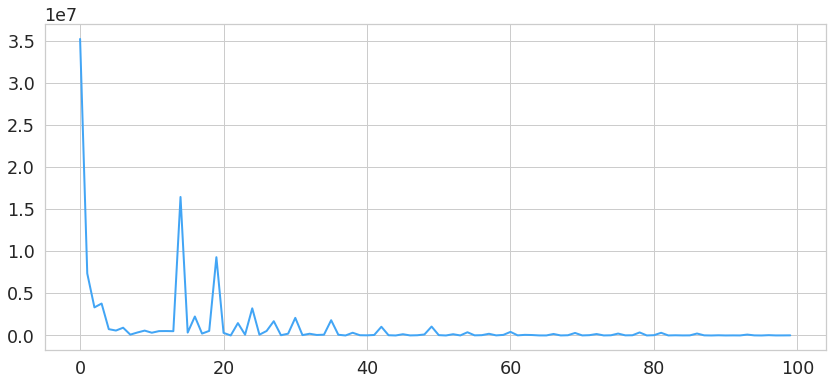

In [44]:
pd.Series(weight1)[:100].plot()

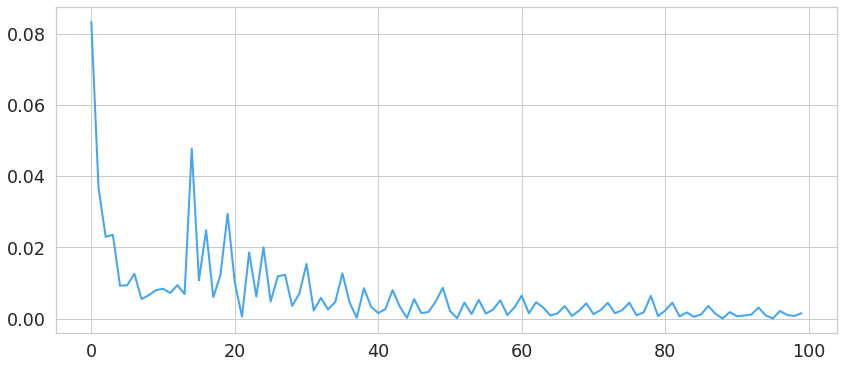

In [45]:
pd.Series(weight2)[:100].plot()

In [46]:
# going to evaluate with the last 28 days
x_train = all_df[all_df["date"] <= "2016-04-24"]
y_train = x_train["sales"]
x_val = all_df[(all_df["date"] > "2016-04-24") & (all_df["date"] <= "2016-05-22")]
y_val = x_val["sales"]
test = all_df[(all_df["date"] > "2016-05-22")]

del all_df
gc.collect()

35

In [47]:
x_train.index = x_train["id"]
x_val.index = x_val["id"]
x_train["weight"] = each_ids_weight
x_val["weight"] = each_ids_weight
x_train

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,week,quarter,dayofyear,mday,black_friday,weight
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_897,0.0,2013-07-13,11325,...,NaN,NaN,NaN,NaN,28,3,194,13,0,0.286843
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_898,0.0,2013-07-14,11325,...,NaN,NaN,NaN,NaN,28,3,195,14,0,0.286843
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_899,0.0,2013-07-15,11325,...,NaN,NaN,NaN,NaN,29,3,196,15,0,0.286843
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_900,0.0,2013-07-16,11325,...,NaN,NaN,NaN,NaN,29,3,197,16,0,0.286843
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1_evaluation,1437,3,0,1,0,d_901,0.0,2013-07-17,11325,...,NaN,NaN,NaN,NaN,29,3,198,17,0,0.286843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_827_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1909,0.0,2016-04-20,11612,...,2.142857,1.964286,1.785714,1.714286,16,2,111,20,0,0.013142
FOODS_3_827_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1910,0.0,2016-04-21,11612,...,2.142857,1.857143,1.892857,1.821429,16,2,112,21,0,0.013142
FOODS_3_827_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,1436,2,9,0,2,d_1911,0.0,2016-04-22,11612,...,2.714286,1.857143,1.928571,1.857143,16,2,113,22,0,0.013142


In [48]:
categoricals = ["item_id", "dept_id", "store_id", "cat_id", "state_id", "event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weight"]
features = x_train.columns[~x_train.columns.isin(useless_cols)]

train_set = lgb.Dataset(x_train[features], y_train, weight=x_train["weight"], categorical_feature=categoricals, free_raw_data=False)
val_set = lgb.Dataset(x_val[features], y_val, weight=x_val["weight"], categorical_feature=categoricals, free_raw_data=False)

In [49]:
# params = {
#     "boosting_type": "gbdt",
#     "metric": "custom",
#     "objective": "custom",
#     "n_jobs": -1,
#     "seed": 236,
#     "learning_rate": 0.01,
#     "bagging_fraction": 0.75,
#     "bagging_freq": 10, 
#     "colsample_bytree": 0.75
# }

params = {
    "boosting_type": "gbdt",
    "metric": "custom",
    "objective": "poisson",
    "learning_rate" : 0.075,
    # "sub_feature" : 0.8,
    "sub_row" : 0.75,
    "bagging_freq" : 1,
    "lambda_l2" : 0.1,
    # "nthread" : 4
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}
poisson_max_delta_step = 0.7

# model estimation
model = lgb.train(params, train_set, num_boost_round=100, early_stopping_rounds=50, 
                  valid_sets=[train_set, val_set], verbose_eval=100, feval=wrmsse)
val_pred = model.predict(x_val[features])
y_pred = model.predict(test[features])
x_val["sales"] = val_pred
test["sales"] = y_pred

Training until validation scores don't improve for 50 rounds
[100]	training's wrmsse: 1.08188	valid_1's wrmsse: 0.595842
[200]	training's wrmsse: 0.921181	valid_1's wrmsse: 0.563058
[300]	training's wrmsse: 0.932737	valid_1's wrmsse: 0.55784
Early stopping, best iteration is:
[261]	training's wrmsse: 0.928873	valid_1's wrmsse: 0.556462


findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


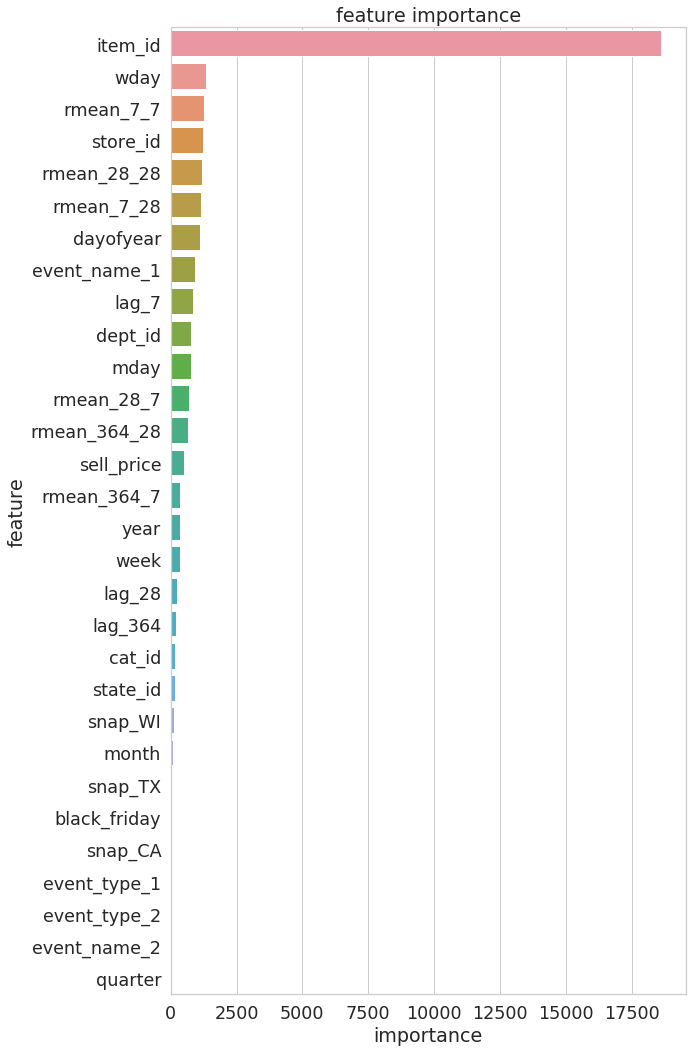

,feature,importance
0,item_id,18620
1,dept_id,768
2,store_id,1240
3,cat_id,159
4,state_id,148
5,wday,1326
6,month,88
7,year,353
8,event_name_1,926
9,event_type_1,1


In [50]:
def display_feature_importance(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df["feature"].isin(cols)]
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title("feature importance")
    plt.tight_layout()
    plt.show()


feature_importance = pd.DataFrame(x_train[features].columns, columns=["feature"])
feature_importance["importance"] = model.feature_importance(importance_type="split")
display_feature_importance(feature_importance)
feature_importance

In [55]:
x_val_rep = x_val.copy()
x_val_rep.index = x_val_rep["id"].str.replace("evaluation", "validation")
x_val_rep["id"] = x_val_rep["id"].str.replace("evaluation", "validation")

In [56]:
predictions_valid = x_val_rep[["id", "date", "sales"]]
predictions_valid = pd.pivot(predictions_valid, index = "id", columns = "date", values = "sales").reset_index()
predictions_valid.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_valid

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.042227,0.887635,0.877003,0.855359,1.044162,1.252178,1.258194,1.055174,0.959199,...,1.112364,1.259511,1.127975,0.922013,0.889252,0.772880,0.765690,0.982212,1.280290,1.228509
1,FOODS_1_001_CA_2_validation,1.131368,1.148981,1.072246,1.461118,1.389631,1.613856,1.520273,0.915067,1.078933,...,0.982797,1.192804,0.827948,0.874186,0.925597,0.902515,0.909052,1.099041,1.359873,1.012688
2,FOODS_1_001_CA_3_validation,1.128851,1.045429,1.025990,1.009659,1.069853,1.285961,0.887900,0.908711,0.828909,...,1.014297,1.154035,1.057955,0.859325,0.778613,0.781370,0.778806,0.902638,1.081709,0.923355
3,FOODS_1_001_CA_4_validation,0.364902,0.331657,0.325123,0.324202,0.373088,0.409898,0.456236,0.336022,0.376694,...,0.290450,0.361839,0.334728,0.273193,0.270838,0.257690,0.257743,0.311343,0.335114,0.349659
4,FOODS_1_001_TX_1_validation,0.204909,0.204871,0.183970,0.183531,0.151858,0.163836,0.165814,0.146920,0.143842,...,0.362631,0.601346,0.527088,0.343427,0.368104,0.342510,0.397414,0.497765,0.558185,0.590125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.247739,0.217702,0.240530,0.240755,0.295544,0.345857,0.375794,0.270928,0.248116,...,0.267135,0.351127,0.333236,0.227925,0.209033,0.207225,0.206101,0.250112,0.264875,0.221657
30486,HOUSEHOLD_2_516_TX_3_validation,0.152217,0.144558,0.153007,0.148937,0.167595,0.182335,0.178978,0.143133,0.133317,...,0.195306,0.183775,0.201823,0.156690,0.139685,0.139748,0.139681,0.191185,0.236073,0.231592
30487,HOUSEHOLD_2_516_WI_1_validation,0.096601,0.092266,0.092211,0.092320,0.091990,0.102772,0.099419,0.111141,0.097445,...,0.116663,0.169876,0.156820,0.120982,0.115309,0.115455,0.115592,0.133622,0.156414,0.151071
30488,HOUSEHOLD_2_516_WI_2_validation,0.051001,0.049972,0.049457,0.092575,0.107719,0.106755,0.104834,0.094668,0.090261,...,0.080848,0.089203,0.088150,0.071230,0.071427,0.070272,0.069355,0.080061,0.085901,0.109721


In [57]:
predictions_eval = test[["id", "date", "sales"]]
predictions_eval = pd.pivot(predictions_eval, index = "id", columns = "date", values = "sales").reset_index()
predictions_eval.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_eval

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.857084,0.771965,0.766978,0.823300,0.809145,0.910688,0.824275,0.781365,0.704900,...,0.875326,0.611350,0.621187,0.669183,0.653868,0.655481,0.689315,0.839809,0.724860,0.731159
1,FOODS_1_001_CA_2_evaluation,0.883771,0.871991,0.764376,0.694935,0.856068,1.140277,0.894589,0.772282,0.730085,...,0.946009,0.701248,0.681058,0.729081,0.698999,0.719539,0.714367,0.902386,0.644702,0.652688
2,FOODS_1_001_CA_3_evaluation,0.704109,0.670128,0.728458,0.687614,0.959767,1.107517,1.160114,0.877829,0.845949,...,1.099980,0.679045,0.694206,0.809882,0.807302,0.749008,0.791813,0.965768,0.665119,0.653050
3,FOODS_1_001_CA_4_evaluation,0.248761,0.256265,0.284187,0.301050,0.291071,0.318508,0.308998,0.662689,0.648560,...,0.776396,0.621496,0.618100,0.670053,0.654461,0.641425,0.647591,0.762988,0.574846,0.571641
4,FOODS_1_001_TX_1_evaluation,0.556847,0.967493,0.651160,0.772851,0.910320,0.920539,1.064577,0.652861,0.639540,...,0.777502,0.546987,0.572712,0.630190,0.643675,0.644879,0.669160,0.780542,0.564542,0.588362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.220083,0.188719,0.170263,0.163280,0.209094,0.241796,0.236606,0.455720,0.372829,...,0.524983,0.443599,0.477752,0.393007,0.362679,0.374087,0.392160,0.547434,0.447118,0.457115
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.176349,0.148311,0.142792,0.144455,0.195309,0.253646,0.273053,0.407438,0.349755,...,0.465711,0.376811,0.404212,0.362735,0.334291,0.331106,0.349071,0.457123,0.387336,0.409740
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.116367,0.115355,0.115355,0.118833,0.142747,0.162966,0.156275,0.363149,0.336650,...,0.453720,0.416321,0.398119,0.340428,0.327279,0.327371,0.343359,0.457867,0.403709,0.384920
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.101571,0.098765,0.096928,0.093631,0.112743,0.113078,0.104772,0.367875,0.339182,...,0.475010,0.396456,0.377928,0.331091,0.322566,0.322997,0.334398,0.439311,0.379373,0.380281


In [58]:
validation_rows = [row for row in submission["id"] if "validation" in row] 
evaluation_rows = [row for row in submission["id"] if "evaluation" in row] 

# predictions_valid, evalはidの順番が違うので、submissionに合わせる意味で必要
validation = submission[submission["id"].isin(validation_rows)]
evaluation = submission[submission["id"].isin(evaluation_rows)]

validation = validation[["id"]].merge(predictions_valid, on = "id")
evaluation = evaluation[["id"]].merge(predictions_eval, on = "id")

final = pd.concat([validation, evaluation])
final.to_csv("case07_eval_poissonweighted_lag_submission.csv", index = False)

In [59]:
# Transformer参考用
# https://github.com/Trigram19/m5-python-starter